This exercise is to cluster seeds according to a 1-NN algorithm, using holdout sets to create training and test data.

# Script

In [7]:
import os
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import requests as req
from matplotlib.colors import ListedColormap
% matplotlib inline

In [8]:
url = 'https://raw.github.com/luispedro/BuildingMachineLearningSystemsWithPython/master/ch02/data'
file = 'seeds.tsv'

In [9]:
#set number of holdout sets for cross validation
num_holdouts = 5

In [10]:
response = req.get(os.path.join(url,file))
bytesstr = response.content

In [11]:
with open(file,mode='w',encoding='utf-8') as f:
    f.write(bytesstr.decode(response.encoding))

In [12]:
#open data set
data = []
target = []
with open(file,'r') as rf:
    lines = [line.strip() for line in rf.readlines()]
    for line in lines:
        tokens = line.split('\t')
        target.append(tokens[-1])
        tokens = [float(t) for t in tokens[:-1]]
        data.append(tokens[:-1])
data = np.array(data)
target = np.array(target)

In [13]:
#create holdout sets k-cross validation
#returns boolean array, True where data is in training set
def get_test_trn_flag(HO_idx):
    holdouts = np.random.randint(num_holdouts,size=len(data))
    in_trn_set = np.array([False if dp==HO_idx else True for dp in holdouts])
    return in_trn_set

In [14]:
#create a distance measure to be able to calculate NN
def euc_dist(p0,p1):
    return math.sqrt(sum((np.array(p0)-np.array(p1))**2))

In [15]:
#returns the label of the NN
def get_nearest_neighbour(test_dp,test_trn_indctrs,features):
    eds = [euc_dist(test_dp,dp) if bln_trn else sys.maxsize for dp, bln_trn in zip(features,test_trn_indctrs)]
    closest = np.array(eds).argmin()
    return target[closest]

In [16]:
#across each holdout set calculate model accuracy
NNs = []
mdl_accs = []
for HOcnt in range(num_holdouts):
    trn_set = get_test_trn_flag(HOcnt)
    test_set = ~trn_set
    NNs = [get_nearest_neighbour(test_dp,trn_set,data) for test_dp in data[test_set]]
    accuracy =[1 if nn==targ else 0 for nn, targ in zip(NNs,target[test_set])]
    mdl_accs.append(np.mean(accuracy))
mdl_accs, 'Mean accuracy is %4.4f' % np.mean(mdl_accs)

([0.90909090909090906,
  0.91176470588235292,
  0.94999999999999996,
  0.8936170212765957,
  0.9285714285714286],
 'Mean accuracy is 0.9186')

Let's have a look at a plot of nearest-neighbour using two dimensions, say compactness and area, indexed by 0 and 2 respectively in the data 

In [17]:
#Create a dataframe to store the data for plotting and a meshgrid to plot NN algorithm
df = pd.DataFrame(data)
df = df[[0,2]].rename(columns={0:'area',2:'compactness'})
#Identify the minimum and maximum and use these plus a margin for the plot range
xmin, ymin = df.apply(min,axis=0)
xmax, ymax = df.apply(max,axis=0)
X = np.linspace(xmin*0.9,xmax*1.1,100)
Y = np.linspace(ymin*0.9,ymax*1.1,100)
X,Y = np.meshgrid(X,Y)

In [18]:
#create a set of coordinates
gridvals = np.vstack([X.ravel(),Y.ravel()]).T
#create a set of points to plot
plt_features = data[:,(0,2)]
#use every point in the seeds set as a training point
all_train = [True for dp in data]
predictions = [get_nearest_neighbour(dp, all_train,plt_features) for dp in gridvals]

#set colour maps for existing features and predicted labels  
feature_cmap = ListedColormap([(1., .0, .0), (.0, 1., .0), (.0, .0, 1.)])
prediction_cmap = ListedColormap([(1., .6, .6), (.6, 1., .6), (.6, .6, 1.)])

#map predictions to numeric labels for colormap
colmapper = {'Canadian':1,'Kama':2,'Rosa':3}
predicted_labels = list(map(colmapper.get,predictions))
target_labels = list(map(colmapper.get,target))

predicted_labels = np.array(predicted_labels).reshape(X.shape)

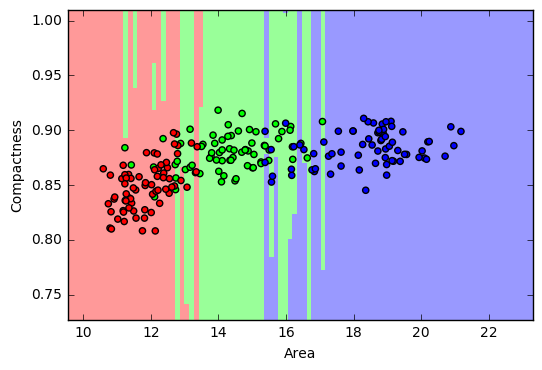

In [19]:
#Set up NN plots
fig, ax = plt.subplots()
ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_xlabel('Area')
ax.set_ylabel('Compactness')
#plot mesh and scatter
ax.pcolormesh(X,Y,predicted_labels,cmap=prediction_cmap)
ax.scatter(data[:, 0], data[:, 2], c=target_labels, cmap=feature_cmap)
plt.show()

In [63]:
#Normalise values and plot again
norm_plt_features = (plt_features - plt_features.mean(axis=0))/plt_features.std(axis=0)

In [64]:
#Recreate the grid values normalised
df = pd.DataFrame(norm_plt_features)
xmin, ymin = df.apply(min,axis=0)
xmax, ymax = df.apply(max,axis=0)
X = np.linspace(xmin*0.9,xmax*1.1,100)
Y = np.linspace(ymin*0.9,ymax*1.1,100)
X,Y = np.meshgrid(X,Y)
gridvals = np.vstack([X.ravel(),Y.ravel()]).T

In [65]:
#rerun predictions
predictions = [get_nearest_neighbour(dp, all_train,norm_plt_features) for dp in gridvals]
predicted_labels = list(map(colmapper.get,predictions))

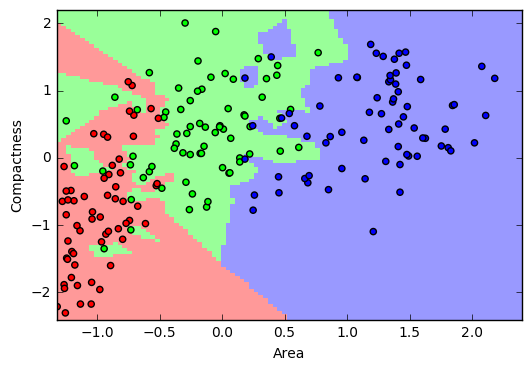

In [36]:
#Set up NN plots
fig, ax = plt.subplots()
ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_xlabel('Area')
ax.set_ylabel('Compactness')
#plot mesh and scatter
ax.pcolormesh(X,Y,predicted_labels,cmap=prediction_cmap)
ax.scatter(norm_plt_features[:, 0], norm_plt_features[:, 1], c=target_labels, cmap=feature_cmap)
plt.show()

# Function
This section creates a function to visualise NN as above. 

In [106]:
def plotNN(NN_function,Xfeature,Yfeature,Xname,Yname,target,predCMap,featCMap,colourmapper):
    
    #create grid values to plot
    data = np.array([Xfeature,Yfeature]).T
    df = pd.DataFrame(data)
    try:
        xmin, ymin = df.apply(min,axis=0)
        xmax, ymax = df.apply(max,axis=0)
        X = np.linspace(xmin*0.9,xmax*1.1,100)
        Y = np.linspace(ymin*0.9,ymax*1.1,100)
        X,Y = np.meshgrid(X,Y)
        gridvals = np.vstack([X.ravel(),Y.ravel()]).T
    except ValueError as e:
        print(e)

    #Use every point as a training point
    all_train = [True for dp in data]
    
    #Predict nearest neighbour of each grid point
    predictions = [NN_function(dp, all_train,data) for dp in gridvals]
    
    #Get numeric colour labels for predictions    
    colour_labels = list(map(colourmapper.get,predictions))
    #reshape labels to 2 dimensional grid for colormesh
    colour_labels = np.array(colour_labels).reshape(X.shape)
        
    #Map target labels to colours
    target_labels = list(map(colourmapper.get,target))
    
    #set up plot
    fig, ax = plt.subplots()
    ax.set_xlim(X.min(),X.max())
    ax.set_ylim(Y.min(),Y.max())
    ax.set_xlabel(Xname)
    ax.set_ylabel(Yname)
    
    #plot mesh and scatter
    ax.pcolormesh(X,Y,colour_labels,cmap=predCMap)
    ax.scatter(Xfeature, Yfeature, c=target_labels, cmap=featCMap)
    plt.show()

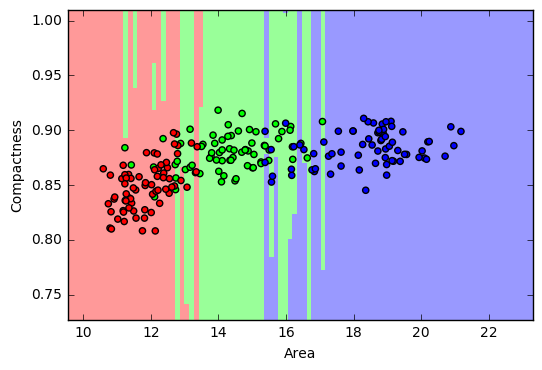

In [107]:
plotNN(get_nearest_neighbour,data[:,0],data[:,2],'Area','Compactness',target,prediction_cmap,feature_cmap,colmapper)

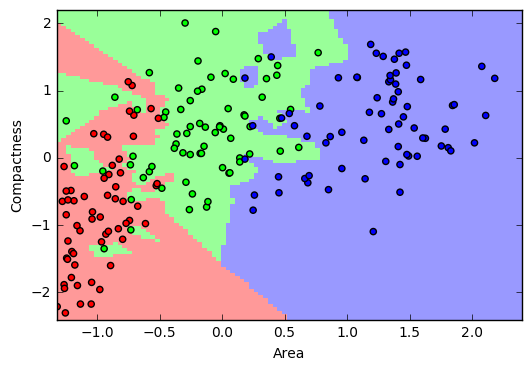

In [108]:
plt_features = data[:,(0,2)]
norm_plt_features = (plt_features - plt_features.mean(axis=0))/plt_features.std(axis=0)
plotNN(get_nearest_neighbour,norm_plt_features[:,0],norm_plt_features[:,1],'Area','Compactness',target, /
       prediction_cmap,feature_cmap,colmapper)